# Analysis

To start, we'll import everything we'll likely need:

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sb
import plotly as pty
from prettytable import PrettyTable 

Before we clean our data, it is a good idea to understand the questions we are trying to answer:

1. Are the packet inter-arrival times drawn from some distribution?
2. Do the observed scans follow the scan schedules as specified by the Android API?
3. Are the packet inter-arrival times distinct for each device?
4. Are there any other patterns in the data that may uniquely identify a device (does it favor a particular channel, packets sent, etc)

Each input file conists of N rows of 2 value pairs, where the first value is the time the packet arrived and the second value is the channel on which the packet was seen:
```
12345.6789 11
12345.9876 1
...
```


This format is excellent to reason about whether our data matches the expected scan schedule specified in the Android source code, to do this we'll plot packet number against the time the packet arrived. If our data does match the expected scan schedule, we'll expect big jumps around 20, 40, 60, and 80 seconds since the phones WiFi was enabled and its screen was kept on. A 10 minute sample was taken for both screen on/off scenarios:

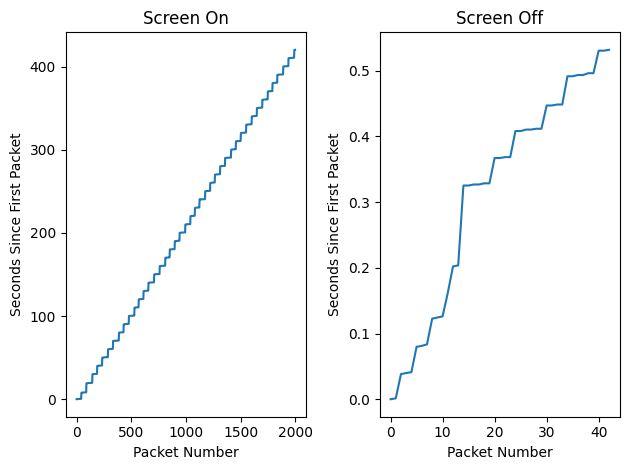

In [106]:
f1 = open("../data/screen_on.txt", "r")
f2 = open("../data/screen_off.txt", "r")

def read_data(filename):
    ret = []
    f1 = open(filename, "r")
    
    for line in f1:
        time, channel = line.strip().split(' ')
        ret.append([float(time), channel])
        
    f1.close()
    return ret
        
        
screen_on = read_data("../data/screen_on.txt")
screen_off = read_data("../data/screen_off.txt")

start_time_off = screen_off[0][0]
start_time_on = screen_on[0][0]

screen_on_plot = []
screen_off_plot = []

for i in range(2000):
    
    if i < len(screen_on) - 1:
        screen_on_plot.append(screen_on[i][0] - start_time_on)
        
    if i < len(screen_off) - 1:
        screen_off_plot.append(screen_off[i][0] - start_time_off)



# plot the screen on dataset
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(2000), screen_on_plot)
ax2.plot(range(len(screen_off_plot)), screen_off_plot)
ax1.set_title('Screen On')
ax2.set_title('Screen Off')
ax1.set_xlabel('Packet Number')
ax2.set_xlabel('Packet Number')
ax1.set_ylabel('Seconds Since First Packet')
ax2.set_ylabel('Seconds Since First Packet')
fig.tight_layout()
plt.show()

Two things we should note right away:

1. When the screen if off, scans are not made. This coincides with the Android source code which has this check:
```java
private void periodicScanTimerHandler() {
    localLog("periodicScanTimerHandler");

    // Schedule the next timer and start a single scan if screen is on.
    if (mScreenOn) {
        startPeriodicSingleScan();
    }
}
```

2. When the screen is on, the scans follow some sort of periodic behavior. 


Because of (1), we'll only look at the data with the screen on.


Let's take a closer look at the first 1000 packets to get a better idea of the periodic behavior.

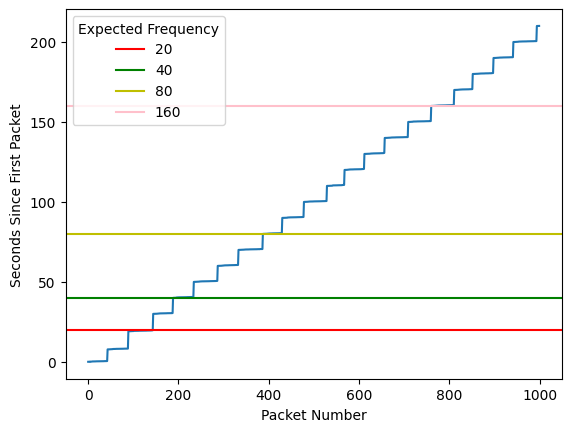

In [107]:
# plot the screen on dataset
plt.plot(range(1000), screen_on_plot[:1000])
plt.axhline(y=20, color='r', linestyle='-', label="20")
plt.axhline(y=40, color='g', linestyle='-', label="40")
plt.axhline(y=80, color='y', linestyle='-', label="80")
plt.axhline(y=160, color='pink', linestyle='-', label="160")
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.legend(title="Expected Frequency")
plt.show()

We can see that the output pattern doesn't match the expected scan frequency as specified by the Android source code. Instead it appears that they occur every 10 seconds:

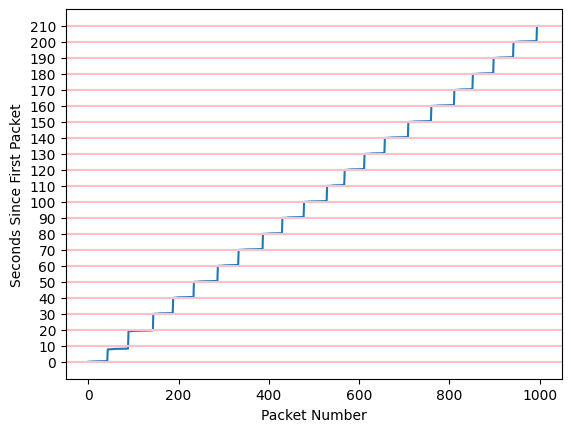

In [108]:
# plot the screen on dataset
plt.plot(range(1000), screen_on_plot[:1000])
labels = [i for i in range(211) if i % 10 == 0]
for line in labels:
    plt.axhline(y=line, color='pink', linestyle='-', label="160")
    

    
plt.yticks(labels)
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.show()

This may have been due to leaving networking screen on (rather than just say, the homescreen. Later on, we'll run more situations and can confirm whether or not different situations behave the same.

From this point on, we won't be using the absolute timestamps. Instead we'll be using inter-arrival time between each packet. Let's convert the old format into something more usable:

```
0.01 1 6
0.007 6 6
...
```

Each row conists of (1) the time between the two packets, (2) the channel the first packet was sent on, and (3) the channel the second packet was sent on. Let's generate this data:

In [109]:
def generate_dataset(raw):
    out = []
    for index, (time, channel) in enumerate(raw):
        if index == 0:
            continue
        
        prev_time, prev_channel = raw[index - 1]
        out.append([float(time) - float(prev_time), prev_channel, channel])
        
    return np.array(out)


screen_on_r = generate_dataset(screen_on)

The next step is figuring out how to remove outliers. Recall that the times between packets in the same scan is small (<<1 second) while the time between two packets in different scans is very large. Therefore, any cutoff around 1 should be acceptable. For now, we'll use 2 as the cutoff although we can revisit it later if something doesn't seem right.

In [110]:
cutoff = 2

In [156]:
def partition_data(data, cutoff):
    bins_close = {}
    bins_far = {}
    for first in ["1", "6", "11"]:
        for second in ["1", "6", "11"]:
            bins_far["{}->{}".format(first, second)] = []
            bins_close["{}->{}".format(first, second)] = []


    for time, start, finish in data:
        time = float(time)
        start = int(start)
        finish = int(finish)
        if time > 0 and time < cutoff:
            bins_close["{}->{}".format(start, finish)].append(time)

        elif time > 0 and time >= cutoff:
            bins_far["{}->{}".format(start, finish)].append(time)
            
    return bins_close, bins_far
            

# data should be a dictionary returned from parition_data
def display_summary_statistics(data, message):
    x = PrettyTable()
    x.field_names = ["Channel", "Median", "Mean", "Standard Deviation", "Min", "Max", "Occurences"]

    rows = []
    for k, v in data.items():
        if len(v) > 0:
            rows.append([k, np.median(v), np.mean(v), np.std(v), np.min(v), np.max(v), len(v)])

    x.add_rows(rows)
    x.align = "r"
    print(message)
    print(x)
    print("\n")

    
close, far = partition_data(screen_on_r, cutoff)
display_summary_statistics(close, "Under 2 Seconds")
display_summary_statistics(far, "Over 2 Seconds")

Under 2 Seconds
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+------------+
| Channel |                Median |                 Mean |   Standard Deviation |                   Min |                 Max | Occurences |
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+------------+
|    1->1 | 0.0024330615997314453 | 0.016766490874352395 | 0.026811723973702014 | 0.0012559890747070312 | 0.44407105445861816 |        616 |
|    1->6 |   0.08040750026702881 |   0.0819623853479113 |   0.0431878288191371 |  0.033653974533081055 | 0.20553994178771973 |         56 |
|    6->6 |  0.002583026885986328 | 0.017749960055918054 |   0.0204484849594133 | 0.0012578964233398438 | 0.12343907356262207 |        917 |
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+-----------

From the table, we can note the following:
1. Channel 11 wasn't used at all
2. Every time a new scan started, it started on channel 1.
3. The mean time between scans is approximately 10 seconds
4. There is a large amount of variance in the inter-arrival times


To be more confident in our observations, we'll need far more samples. By taking 5 different 30 minute samples, we should get enough events to get a reliable data set.

Let's take a look at the distribution of data by plotting them as box plots.





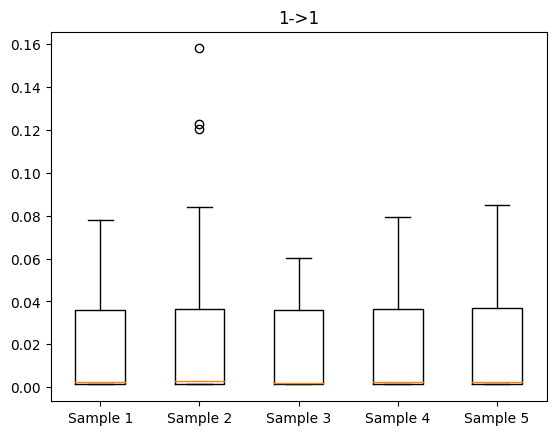

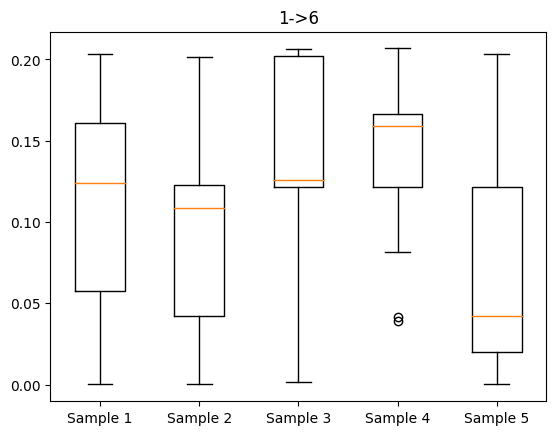

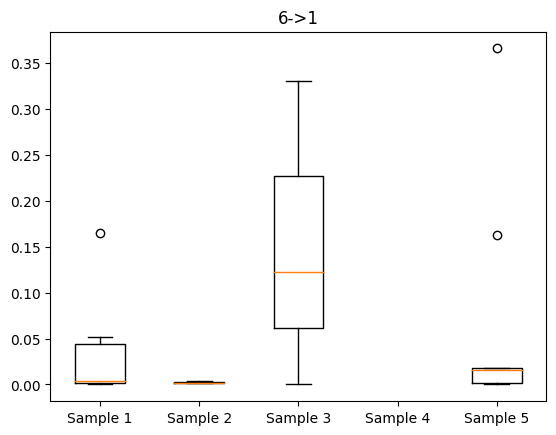

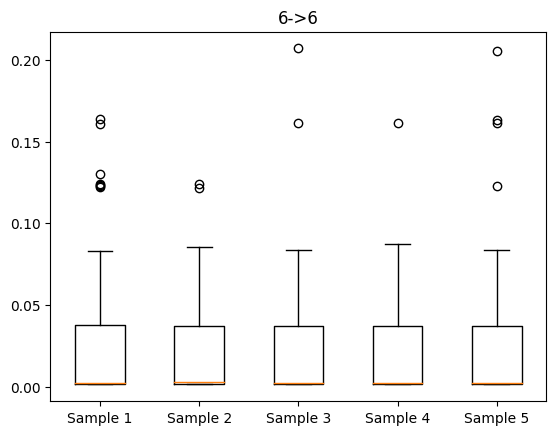

In [112]:
# each boxplot is a dataset
# boxplots are useful for displaying summary statistics for several samples
def generate_boxplots(data_list, title):
    fig, ax = plt.subplots()
    ax.boxplot(data_list)
    ax.set_xticklabels(["Sample {}".format(i + 1) for i in range(5)])
    ax.set_title(title)
    plt.show()


# each line will be a dataset
# a line plot might reveal a pattern in interarrival times
def generate_line_graph(data_list, title):
    pass


# each data set is a seperate box plot
# useful for seeing an overall picture of what the data is like
def display_box_chart(data_list, title):
    fig, ax = plt.subplots()
    labels = ["sample{}".format(i + 1) for i in range(5)]
    ax.barh(labels, data_list)
    ax.set_title(name)
    plt.show()


f1 = read_data("../data/sample1.txt")
f2 = read_data("../data/sample2.txt")
f3 = read_data("../data/sample3.txt")
f4 = read_data("../data/sample4.txt")
f5 = read_data("../data/sample5.txt")

s1 = generate_dataset(f1)
s2 = generate_dataset(f2)
s3 = generate_dataset(f3)
s4 = generate_dataset(f4)
s5 = generate_dataset(f5)

# closeX contains all of the samples for sample X
close1, _ = partition_data(s1, cutoff)
close2, _ = partition_data(s2, cutoff)
close3, _ = partition_data(s3, cutoff)
close4, _ = partition_data(s4, cutoff)
close5, _ = partition_data(s5, cutoff)

# we need to extract each of the permutations into its own structure (so we compare alikes)
grouped = [close1, close2, close3, close4, close5]
for start in ["1", "6", "11"]:
    for end in ["1", "6", "11"]:
        res = []
        name = "{}->{}".format(start, end)
        valid = False
        for sample in grouped:
            if len(sample.get(name)) == 0:
                res.append([])
            else:
                res.append(sample.get(name))
                valid = True
                
        
        # generate the plots
        if valid:
            generate_boxplots(res, name)
        
        

From the boxplots above, we can note that:
1. Channel 11 was not used at all.
2. The inter-arrival times for two packets on the same channel are rather consistent (even the outliers seem to be choosing from a discrete set of possibilities)
3. The inter-arrival times for two packets on different channels is far less consistent.

Recall that when we graphed the absolute timestamps with our initial sample, we observed that scans seemed to occur every 10 seconds rather than following the scan plan laid out in the Android source code. This would be a good time to confirm those suspicions. Let's plot two of our new samples to confirm our suspicions.

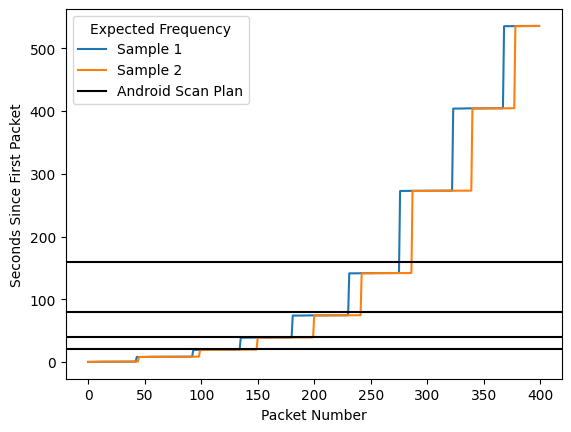

In [113]:
p1 = np.array(f1, dtype=np.double)[:, 0]
p1 = p1 - p1[0]

p2 = np.array(f2, dtype=np.double)[:, 0]
p2 = p2 - p2[0]


# plot the screen on dataset
plt.plot(range(400), p1[:400], label="Sample 1")
plt.plot(range(400), p2[:400], label="Sample 2")
plt.axhline(y=20, color='black', linestyle='-')
plt.axhline(y=40, color='black', linestyle='-')
plt.axhline(y=80, color='black', linestyle='-')
plt.axhline(y=160, color='black', linestyle='-', label="Android Scan Plan")
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.legend(title="Expected Frequency")
plt.show()

We can see that this pattern roughly follows the expected Android scan plan. Therefore, keeping an android phone on the networking screen accelerates scans. This makes sense, since if someone is waiting at the network screen, they are expecting to see or connect to a new network.

Let's expand our samples to include 2 more devices to compare the inter-arrival times between them. When considering these devices, we need a strategy to make sure we are capturing all of the traffic for one device. Some things to note are:

1. If there is MAC randomization, then we must use the signal strength to determine which packets are from the phone (phone is right beside the dongle so we should expect the packets from the phone to have the highest signal strength). To confirm our suspicions, we can plot the absolute timestamps are see if they produce the expected pattern (Android Scan Plan)

2. If there is no MAC randomization, we can just find the MAC address of the phone and use that. The number of packets sent by a single address would be a good start.

Let's start by determining if there is MAC randomization. If MAC randomization if not used, we expect a large number of packets associated with each address.

Running ` tshark -r sample6.pcap | cut -d' ' -f3 | uniq -c | sort -b -n -r | head -n 30` we get the most commonly used source addresses and the number of times they are used:

```
33 62:4f:2b:62:0f:fe
21 02:cc:99:8b:52:a6
19 02:cc:99:8b:52:a6
18 a8:86:60:da:7d:7b
18 72:f7:e8:52:9a:12
18 1a:4f:01:06:6b:db
17 a8:86:60:da:7d:7b
16 fa:48:b1:72:ec:91
16 e6:12:33:ac:bc:5f
16 Apple_ec:0f:7e
16 Apple_e3:ba:4a
16 Apple_0e:fd:ba
16 a8:86:60:da:7d:7b
16 72:f7:e8:52:9a:12
16 62:4f:2b:62:0f:fe
16 56:9b:cd:d3:6d:ea
16 56:9b:cd:d3:6d:ea
16 0e:4f:62:40:e7:ee
16 0e:4f:62:40:e7:ee
16 0e:4f:62:40:e7:ee
16 0e:4f:62:40:e7:ee
15 f6:b0:94:29:96:6f
15 f6:b0:94:29:96:6f
15 ba:79:46:ae:34:0e
15 a8:86:60:da:7d:7b
15 92:20:7e:f7:a3:dd
15 0e:4f:62:40:e7:ee
14 MegaWell_bb:72:bf
```

Since the number of times we see each address is rather small relative to the total number of addresses seen (~17000) , the data suggests that we indeed are dealing with MAC randomization. Therefore we must turn to some binary classifier that decides whether or not a packet belongs to our device. 

## Classifying Packets
A number of factors may be used to classify our packet:

1. The signal strength
2. Time since last packet
3. The source address (studies have shown that addresses are eventually recycled)

The only reliable factor we'll have is the signal strength. Time since last packet is dependent on our previous classifications, which may be incorrect. Source address would likely require a HUGE sample, which we won't have access to in the field.

Finding our packet capture therefore boils down to finding a threshold (x) for our classification. If the signal strength is greater than x, label it as part of our capture, otherwise label it as external traffic. One important question is which error type we prefer. False positives (type I) may potentially skew our data, while false negatives (type II) may reduce the size of our sample making our conclusions unreliable. Given that our sample sizes are very large, we prefer to have type II errors by raising our threshold. 

Let's take a look at some summary statistics for our signal strengths:

```bash
tcpdump -r $1 2>/dev/null | 
awk '{if ($4 ~ /bad-fcs/) {print $12} else {print $11}}' | 
rg -o '[0-9]+' |
python3 -c ' 
import numpy as np
import sys
from pandas import Series
import pandas as pd

x = []
for line in sys.stdin:
  x.append(int(line.strip()))

x = Series(data=x)
print(x.describe())
'
```

Yields us:
    
```
count       39001.000000
mean        80.315453
std         10.342055
min         11.000000
25%         77.000000
50%         82.000000
75%         87.000000
max        100.000000
dtype: float64
```

Our standard deviation is low compared to our mean, which suggests that our data is somewhat concentrated around the mean. However, we have no way of finding a reasonable threshold without knowing the distribution of our data. Let's eyeball the CDF and see if it's somewhat normal:

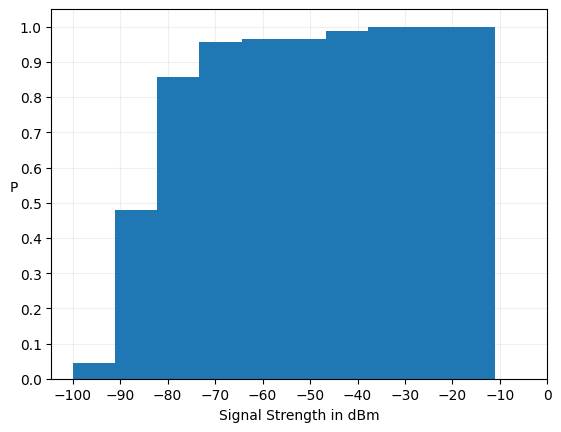

In [114]:
f = open("../data/signal_strengths.txt", "r")

x = []
for line in f:
    x.append(-1 * int(line.strip()))

x = Series(data=x)

plt.hist(x, cumulative=True, density=True)
plt.xlabel('Signal Strength in dBm')
plt.ylabel('P', rotation=0)
plt.xticks([-1 *i for i in range(101) if i % 10 == 0])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, alpha=0.2)
plt.rc('axes', axisbelow=True)
plt.show()
f.close()

From the CDF, we can see that this dataset does not appear normal. This makes selecting a threshold more difficult, and more like a game of trial and error. Let's start with arbitrary threshold and see what kind of distribution we get:

In [115]:
signal_threshold = -60

The first thing we'll check is how many samples we should expect (from our first device without MAC randomization). Since both of them presumeably follow the Android scan plan, we can expect similar amounts of packets being sent over the 30 minutes:

In [116]:
d1 = read_data("../data/sample1.txt")
print("Number of Packets over 30 minutes from Galaxy s6:", len(d1))

Number of Packets over 30 minutes from Galaxy s6: 843


Since we do not know which packets belong to us, we need a new way of reading in the data. Cells moving forward expect the format of the data files to be the following:

```
TIME CHANNEL SIGNAL-STRENGTH
123456.789 1 -90
123456.987 6 -84
```




In [117]:
def read_data_with_ss(filename):
    x = []
    with open(filename, "r") as file:
        for line in file:
            time, channel, signal = line.strip().split(' ')
            x.append([float(time), channel, int(signal)])
            
    return x

def partition(data, t):
    stronger = []
    weaker = []

    for x in data:
        if x[2] > signal_threshold:
            stronger.append(x)
        else:
            weaker.append(x)
            
    return np.array(stronger, dtype=np.float64), np.array(weaker, dtype=np.float64)
            
            

d1 = read_data_with_ss("../data/sample6.txt")
stronger, weaker = partition(d1, signal_threshold)

We know that roughly 843 packets are sent over the 30 minutes, so lets try to partiton the data so that the stronger array is about 900 entries long

In [118]:
signal_threshold = -40
s,w = partition(d1, signal_threshold)

This looks about right, let's plot it and see if we get a similar result as the previous phone:

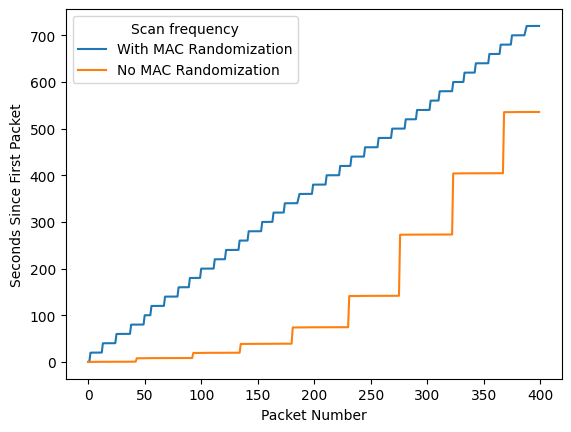

In [119]:
times = np.array([x[0] for x in s])
times = times - times[0]


# plot the screen on dataset
plt.plot(range(400), times[:400], label="With MAC Randomization")
plt.plot(range(400), p1[:400], label="No MAC Randomization")
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.legend(title="Scan frequency")
plt.show()

Hmmmm. Thats not good, this looks pretty similar to having scans every 10 seconds:

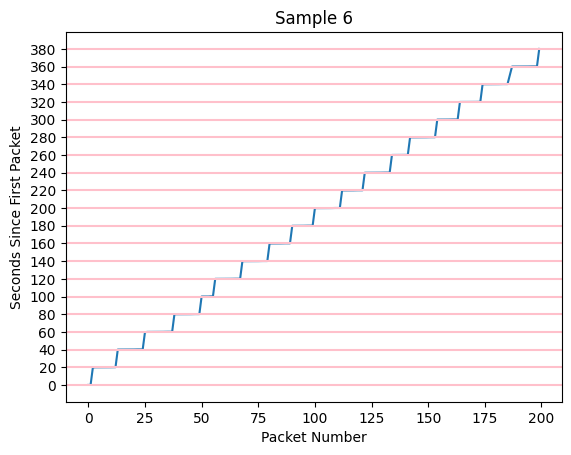

In [120]:
# plot the screen on dataset
plt.plot(range(200), times[:200])
labels = [i for i in range(381) if i % 20 == 0]
for line in labels:
    plt.axhline(y=line, color='pink', linestyle='-', label="160")
    

    
plt.yticks(labels)
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.title("Sample 6")
plt.show()

It appears that scans occur every 20 seconds for this sample. Let's take a look at the rest:

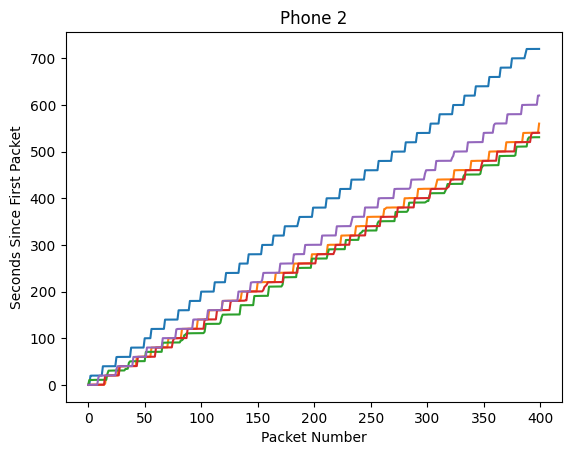

In [143]:
signal_threshold = -40

d6 = read_data_with_ss("../data/sample6.txt")
d7 = read_data_with_ss("../data/sample7.txt")
d8 = read_data_with_ss("../data/sample8.txt")
d9 = read_data_with_ss("../data/sample9.txt")
d10 = read_data_with_ss("../data/sample10.txt")
d11 = read_data_with_ss("../data/sample11.txt")
d12 = read_data_with_ss("../data/sample12.txt")
d13 = read_data_with_ss("../data/sample13.txt")
d14 = read_data_with_ss("../data/sample14.txt")
d15 = read_data_with_ss("../data/sample15.txt")


s6, w6 = partition(d6, signal_threshold)
s7, w7 = partition(d7, signal_threshold)
s8, w8 = partition(d8, signal_threshold)
s9, w9 = partition(d9, signal_threshold)
s10, w10 = partition(d10, signal_threshold)
s11, w11 = partition(d11, signal_threshold)
s12, w12 = partition(d12, signal_threshold)
s13, w13 = partition(d13, signal_threshold)
s14, w14 = partition(d14, signal_threshold)
s15, w15 = partition(d15, signal_threshold)


all_sets_phone2 = [s6,s7,s8,s9,s10]
all_sets_phone3 = [s11,s12,s13,s14,s15]




for x in all_sets_phone2:
    time_x = x[:, 0]
    time_x = time_x - time_x[0]
    plt.plot(time_x[:400])
    
    
# plot the screen on dataset
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.title("Phone 2")
plt.show()






They all behave similarly. Dang.

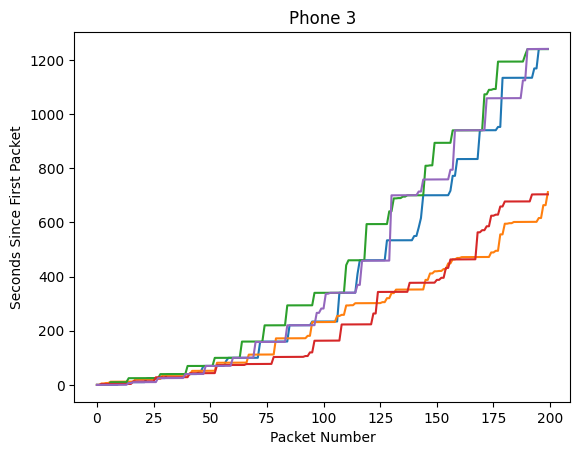

In [149]:
for x in all_sets_phone3:
    time_x = x[:, 0]
    time_x = time_x - time_x[0]
    plt.plot(time_x[:200])
    
    
# plot the screen on dataset
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.title("Phone 3")
plt.show()

This looks to be a bit more reasonable, let's see how they stack up compared to the android scan plan:

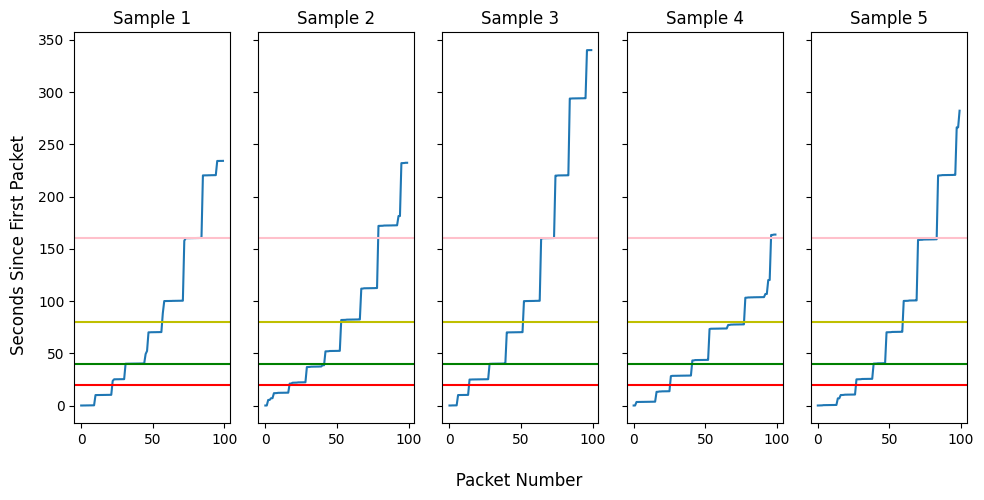

In [148]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(10, 5))
for i in range(len(all_sets_phone3)):
    time_x = all_sets_phone3[i][:, 0]
    time_x = time_x - time_x[0]
    ax[i].plot(time_x[:100])
    ax[i].axhline(y=20, color='r', linestyle='-', label="20")
    ax[i].axhline(y=40, color='g', linestyle='-', label="40")
    ax[i].axhline(y=80, color='y', linestyle='-', label="80")
    ax[i].axhline(y=160, color='pink', linestyle='-', label="160")
    ax[i].set_title('Sample {}'.format(i + 1))
    
    
    
# plot the screen on dataset
fig.supxlabel('           Packet Number')
fig.supylabel('Seconds Since First Packet')
fig.tight_layout()
plt.show()

This looks more similar to what we expect. At this point, it may be worthwhile to tune our signal threshold to remove any undesirable noise (particularily in the 4th sample). -40 seems to keep the cleanest graphs, so its what we'll stick with. When we get to the actual analysis, we'll remove any outliers to reduce the effects of external noise. Lets get the data into the old format: `123456.789 11` and generate some summary statistics:

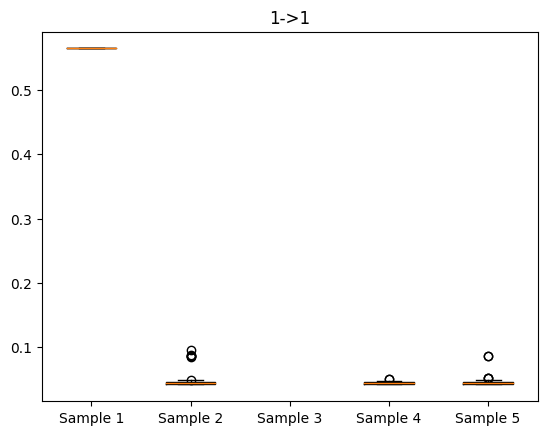

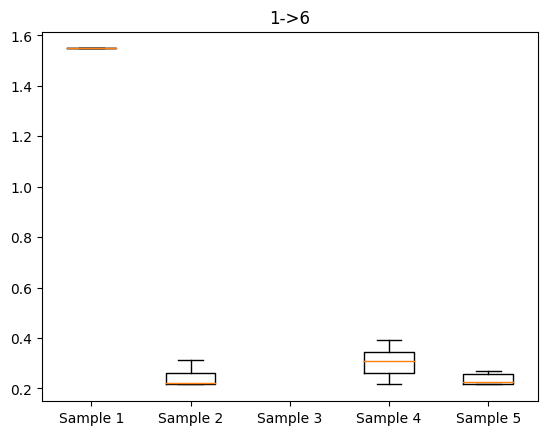

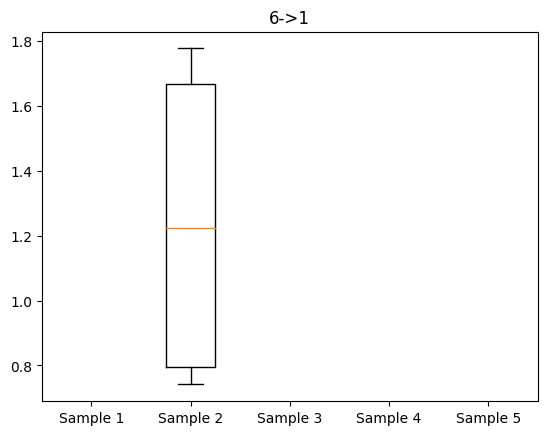

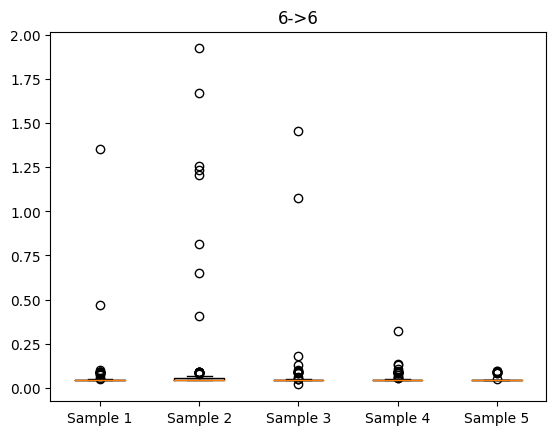

In [159]:
r11 = s11[:, [0,1]]
r12 = s12[:, [0,1]]
r13 = s13[:, [0,1]]
r14 = s14[:, [0,1]]
r15 = s15[:, [0,1]]

d11 = generate_dataset(r11)
d12 = generate_dataset(r12)
d13 = generate_dataset(r13)
d14 = generate_dataset(r14)
d15 = generate_dataset(r15)

close11, _ = partition_data(d11, cutoff)
close12, _ = partition_data(d12, cutoff)
close13, _ = partition_data(d13, cutoff)
close14, _ = partition_data(d14, cutoff)
close15, _ = partition_data(d15, cutoff)


rel_p3 = [close11, close12, close13, close14, close15]

for start in ["1", "6", "11"]:
    for end in ["1", "6", "11"]:
        res = []
        name = "{}->{}".format(start, end)
        valid = False
        for sample in rel_p3:
            if len(sample.get(name)) == 0:
                res.append([])
            else:
                res.append(sample.get(name))
                valid = True
                
        
        # generate the plots
        if valid:
            generate_boxplots(res, name)



